In [13]:
### CBF imports #########################################
import numpy as np
import matplotlib.pyplot as plt
from data import make_rectangle, insert_shape, plot_data
from agent import Agent
from optim import cas_train_cbf, cvx_train_cbf, hjoint
from utils import plot_cbf
#########################################################

### HJB imports #########################################
import jax
import jax.numpy as jnp
from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import hj_reachability as hj
#########################################################

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


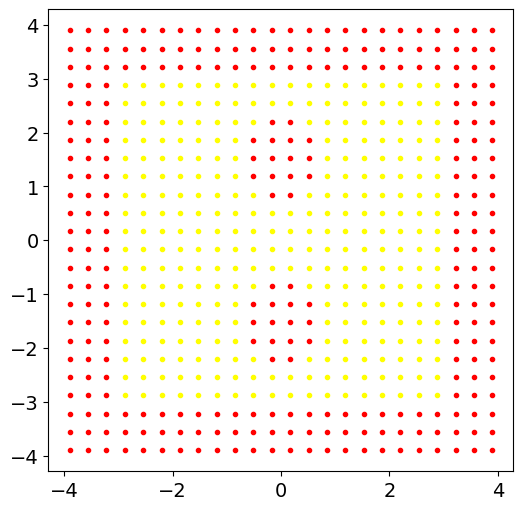

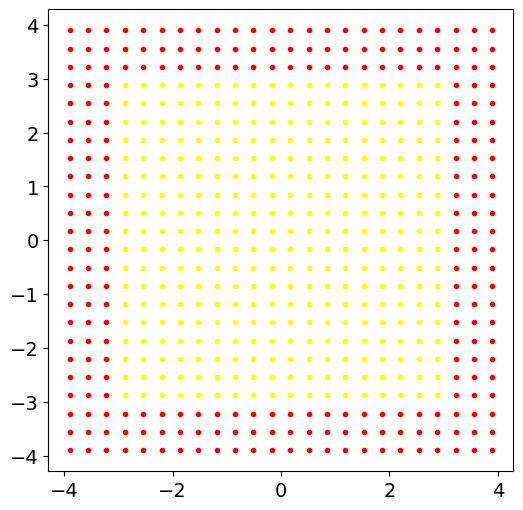

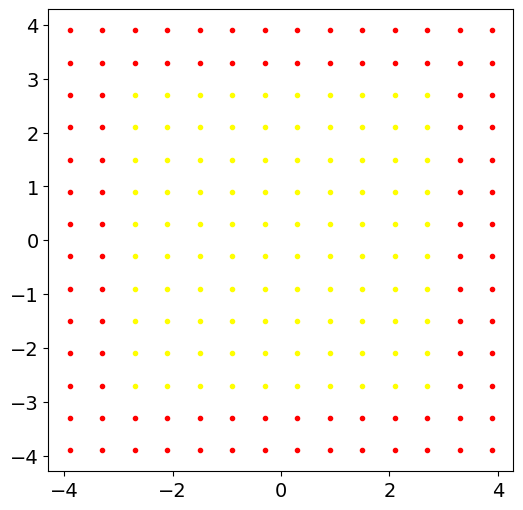

In [14]:
width=6
density=10

### Make grid and obstacles ###
grid, params, obs_dict = make_rectangle(height=width, width=width, density=density, unsafe_margin=0.3, center=(0,0), return_params=True)
obs_dict = insert_shape(np.array([0,  1.5]), grid, obs_dict, shape='circle', scale=0.75, theta=0)
obs_dict = insert_shape(np.array([0, -1.5]), grid, obs_dict, shape='circle', scale=0.75, theta=0)

### Make constraints ###
c_grid, c_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=0.3, center=(0,0))
s_grid, s_obs_dict = make_rectangle(height=width, width=width, density=density/3, unsafe_margin=0.3, center=(0,0))

### Bicycle information ###

### Make HJB grid ###
lo, hi, n = params

lo = lo + (0       ,)
hi = hi + (2*jnp.pi,)
n  = n  + (60      ,)

hjb_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo, hi), n)

plot_data(  grid,   obs_dict, size=6)
plot_data(c_grid, c_obs_dict, size=6)
plot_data(s_grid, s_obs_dict, size=6)

(576, 2)
(24, 24, 60)


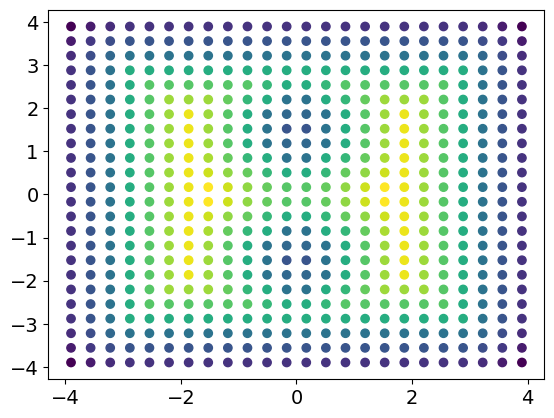

In [36]:
### Make signed distance function ###
l = np.empty(hjb_grid.states.shape[:-1])

obs_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] != 0])
fre_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] == 0])

for i in range(n[0]):
    for j in range(n[1]):
        for k in range(n[2]):
            if obs_dict[tuple(np.round(np.array(hjb_grid.states[i, j, k, :-1]), 3))] != 0:
                l[i, j, k] = -np.min(np.linalg.norm(fre_coords - hjb_grid.states[i, j, k, :2], axis=1))
            else:
                l[i, j, k] =  np.min(np.linalg.norm(obs_coords - hjb_grid.states[i, j, k, :2], axis=1))

print(grid.shape)
print(l.shape)

plt.scatter(grid[:,0], grid[:,1], c=l[...,0].reshape(-1, 1))
plt.show()

In [4]:
l = jnp.array(l)
#values = l - 5
#init = jnp.linalg.norm(hjb_grid.states[...], axis=-1) - 5
values = l 
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube,
                                                  value_postprocessor      =hj.solver.static_obstacle(l))

In [5]:
dynamics = hj.systems.Planar()
time = 0.
target_time = -10
target_values = hj.step(solver_settings, dynamics, hjb_grid, time, values, target_time)

100%|###############################################################################################################################################| 10.0000/10.0 [00:08<00:00,  1.13sim_s/s]


<Figure size 640x480 with 0 Axes>

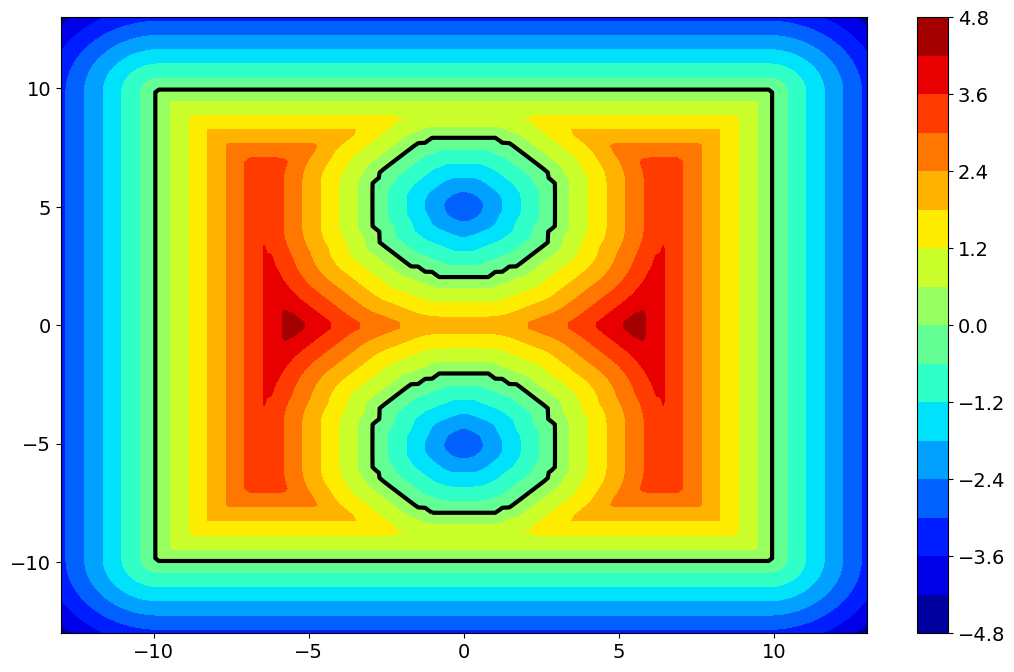

In [6]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(hjb_grid.coordinate_vectors[0], hjb_grid.coordinate_vectors[1], target_values[:, :].T, levels=16)
plt.colorbar()
plt.contour(hjb_grid.coordinate_vectors[0],
            hjb_grid.coordinate_vectors[1],
            target_values[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)

In [7]:
times = np.linspace(0, -30, 58)
initial_values = l
all_values = hj.solve(solver_settings, dynamics, hjb_grid, times, initial_values)

100%|###############################################################################################################################################| 30.0000/30.0 [00:27<00:00,  1.08sim_s/s]


In [8]:
vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), 15*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))


def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 all_values[i, :, :].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :].T,
                levels=0,
                colors="black",
                linewidths=3)


render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation

In [9]:
import cvxpy as cp
from utils import idx_to_coords
from controls import hjb_controls
### Test 
x = hjb_grid.states[2, 3]
print(hjb_controls(x, dynamics, hjb_grid, all_values[-1]))



[0.41999999 0.41999999]


In [10]:
sensor_radius=1.5
a = Agent((0, 0), grid, obs_dict, width=width, sensor_radius=sensor_radius)


### scan states ####################
scan_safe, scan_unsafe = a.scan()
rx = 2*sensor_radius
samples  = a.sample(rx, grid=s_grid)
####################################


### unsafe states ##############################
if scan_unsafe.shape[0] != 0:
    x_unsafe = np.vstack((scan_unsafe, samples))
else: 
    x_unsafe = samples
################################################


### safe & buffer states/controls ##########################################################
n_safe = scan_safe.shape[0]
# prev (0.2, 0.50)
n_mult = 0.5
prc    = 0.70

x_buffer, x_safe = a.make_buffer(scan_safe, int(n_mult * n_safe), prc)
u_buffer = np.array([hjb_controls(x, dynamics, hjb_grid, all_values[-1]) for x in x_buffer])
u_safe   = np.array([hjb_controls(x, dynamics, hjb_grid, all_values[-1]) for x in x_safe])
############################################################################################

rc = sensor_radius * 1
C = []
for x in c_grid:
    if np.linalg.norm(x - a.pos) <= rc:
        C.append(x)
C = np.array(C)
a.centers.append(C)

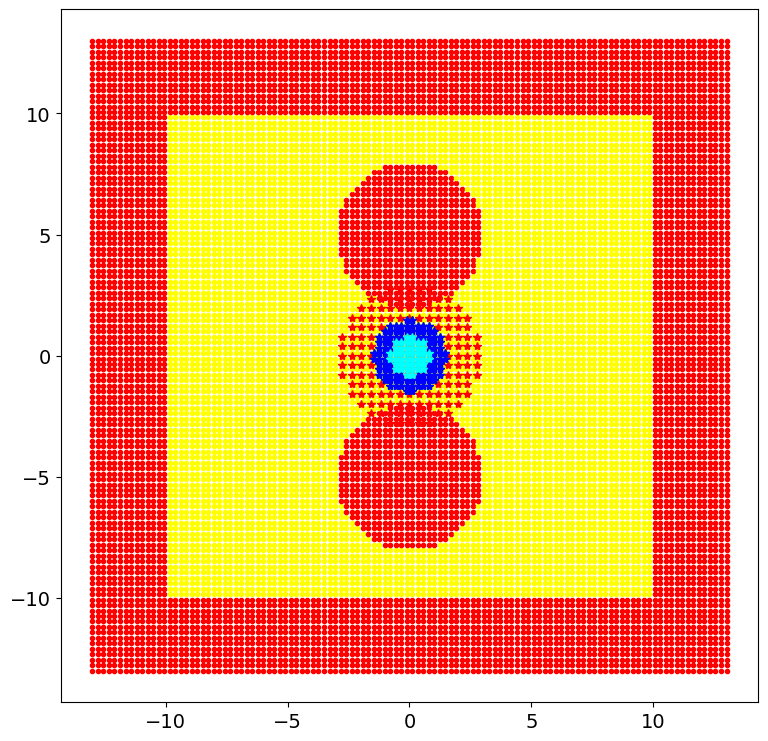

In [11]:
plot_data(grid, obs_dict, [(x_unsafe, "red"),
                           (C       , "green"),
                           (x_buffer, "blue"),
                           (x_safe  , "cyan"), ])

In [12]:
params = {}
theta_max    =  1000 ; params["max_theta"]  = theta_max
sum_theta    = -0.1  ; params["sum_theta"]    = sum_theta
gamma_safe   =  0.3  ; params["gamma_safe"]   = gamma_safe
gamma_unsafe = -0.3  ; params["gamma_unsafe"] = gamma_unsafe
gamma_dyn    =  0.1  ; params["gamma_dyn"]    = gamma_dyn
params["dynamics"] = dynamics
theta = cvx_train_cbf(C, x_safe, u_safe, x_unsafe, x_buffer, u_buffer, params)
a.thetas.append(theta)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jun 06 04:58:34 AM: Your problem has 140 variables, 317 constraints, and 0 parameters.
(CVXPY) Jun 06 04:58:34 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 06 04:58:34 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 06 04:58:34 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 06 04:58:34 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 06 04:58:34 AM: Compiling problem (target solver=CLARABEL

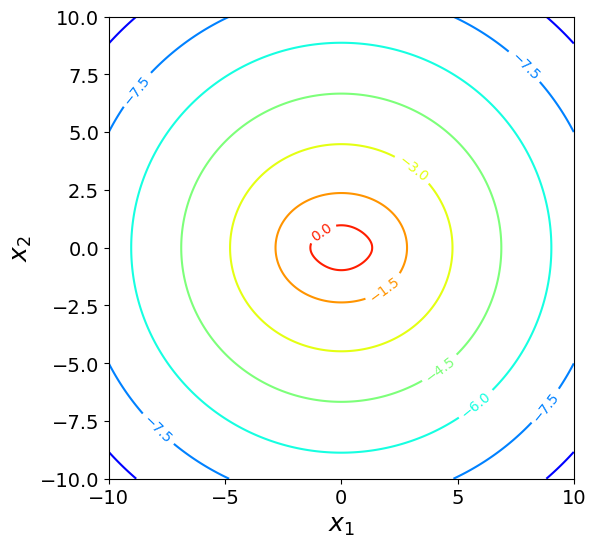

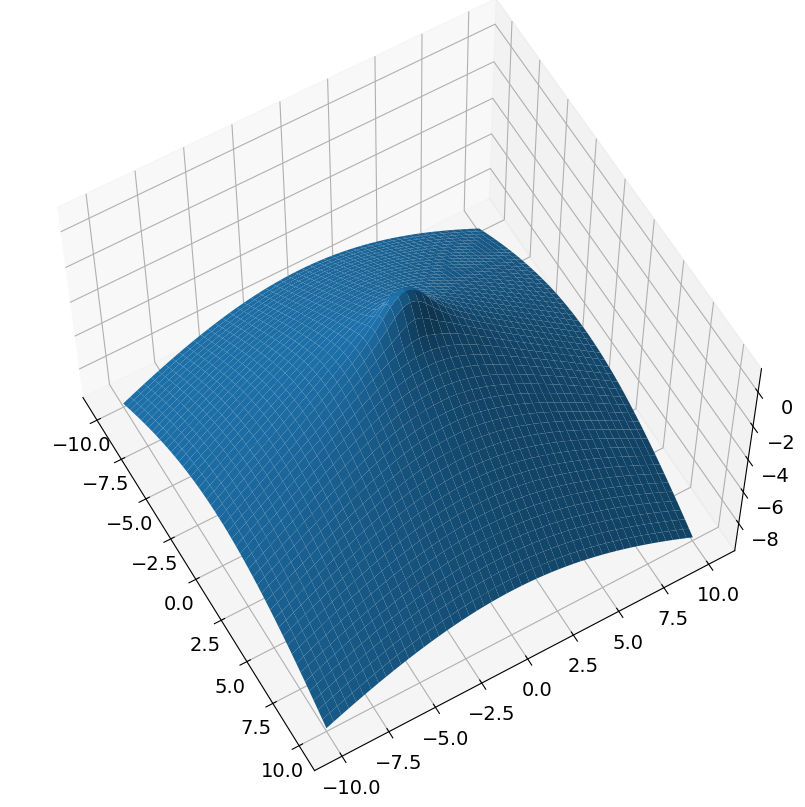

In [13]:
plot_cbf(a.width, a.thetas, a.centers)

In [14]:
pos = 0
neg = 0
for elem in theta:
    if elem < 0:
        neg += elem
    else:
        pos += elem
print(neg/pos)

[-1.28765983]


In [ ]:
a.pos = np.array([0, 0])
a.t   = 0
tol   = 0.1
for i in range(30):
    prev_pos = a.pos  
    while np.linalg.norm(a.pos - prev_pos) <= 0.5:
        target=a.width*np.random.rand(2) - a.width/2
        while hjoint(target, a.thetas, a.centers) > 0:
            target=a.width*np.random.rand(2) - a.width/2
        print("target:", target) 
        a.goto(target, T=2, tend=10, tol=tol) 
        print("dx:", np.linalg.norm(a.pos - prev_pos))
 
    '''
    first=True
    while hjoint(a.pos, a.thetas, a.centers) >= 1 or first:
        a.goto(target, T=7, tend=150, tol=tol)
        first = False
    '''
        
    scan_safe, scan_unsafe = a.scan()
    samples  = a.sample(rx, grid=s_grid) 
    if scan_unsafe.shape[0] != 0:
        x_unsafe = np.vstack((scan_unsafe, samples))
    else: 
        x_unsafe = samples 
    n_safe = scan_safe.shape[0]
    
    x_buffer, x_safe = a.make_buffer(scan_safe, int(n_mult * n_safe), prc) 
    u_buffer = np.array([hjb_controls(x, dynamics, hjb_grid, all_values[-1]) for x in x_buffer])
    u_safe   = np.array([hjb_controls(x, dynamics, hjb_grid, all_values[-1]) for x in x_safe])
    
    C  = []
    for x in c_grid:
        if np.linalg.norm(x - a.pos) <= rc:
            C.append(x)
    C = np.array(C)
    a.centers.append(C)
    plot_data(grid, obs_dict, [(x_unsafe, "red"),
                               (C       , "green"),
                               (x_buffer, "blue"),
                               (x_safe  , "cyan")])

    theta = cvx_train_cbf(C, x_safe, u_safe, x_unsafe, x_buffer, u_buffer, params)
    print("vvvvvvvv this cbf vvvvvvvv")
    plot_cbf(a.width, [theta], [C])
    print("^^^^^^^^ this cbf ^^^^^^^^")
    a.thetas.append(theta)
    plot_cbf(a.width, a.thetas, a.centers)

target: [-8.78997636 -6.70435291]
position is [0 0]
h is [[1.10933075]]
start time is 0


/home/paul/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `teval`.
  warn("The following arguments have no effect for a chosen solver: {}."
